# Implémentation des modèles avec TensorFlow

In [1]:
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from scikeras.wrappers import KerasRegressor, KerasClassifier
from sklearn.model_selection import GridSearchCV

import os
import sys
sys.path.append(os.path.abspath(os.path.join('..')))
from src.tf.tf_wrapper import *

In [2]:
df = pd.read_csv("../data/health_lifestyle_dataset_cleaned.csv")

In [3]:
regression_target = ['cholesterol', 'calories_consumed']
features_reg = df.drop(columns=regression_target).values
regression_labels = df[regression_target].values

In [4]:
scaler_y = StandardScaler()
scaler_y.fit(df[regression_target])

,copy,True
,with_mean,True
,with_std,True


# Régression

On cherche à prédire le taux de cholesterol et les calories consomées (les colonnes ```cholesterol``` et ```calories_consumed```).

In [5]:
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(features_reg, regression_labels, test_size=0.2, random_state=42)

In [6]:
model_reg = KerasRegressor(
    model=build_tf_regressor,
    nb_features=X_train_reg.shape[1],
    layers_count=2,
    width=64,
    activation='relu',
    dropout_rate=0.0,
    learning_rate=1e-3,
    epochs=10,
    batch_size=32,
    verbose=0
)

In [7]:
# Notez l'utilisation du préfixe "model__" pour les arguments de build_tf_regressor
param_grid_reg = {
    "model__layers_count": [2, 3],
    "model__width": [64, 128],
    "model__activation": ["relu", "tanh"],
    "model__dropout_rate": [0.0, 0.2],
    "model__learning_rate": [1e-1, 1e-3],
    "epochs": [30],
    "batch_size": [32]
}

In [8]:
grid = GridSearchCV(estimator=model_reg, param_grid=param_grid_reg, cv=3, scoring="r2", n_jobs=-1, verbose=2)
grid_result_reg = grid.fit(X_train_reg, y_train_reg)

print(f"Meilleur score : {grid_result_reg.best_score_}")
print(f"Meilleurs paramètres : {grid_result_reg.best_params_}")

Fitting 3 folds for each of 32 candidates, totalling 96 fits
Meilleur score : -0.00024441723015037703
Meilleurs paramètres : {'batch_size': 32, 'epochs': 30, 'model__activation': 'tanh', 'model__dropout_rate': 0.0, 'model__layers_count': 3, 'model__learning_rate': 0.001, 'model__width': 64}


Meilleur score : -0.00024441723015037703

Meilleurs paramètres : {'batch_size': 32, 'epochs': 30, 'model__activation': 'tanh', 'model__dropout_rate': 0.0, 'model__layers_count': 3, 'model__learning_rate': 0.001, 'model__width': 64}

In [9]:
best_model_reg = grid_result_reg.best_estimator_

In [10]:
y_pred_scaled = best_model_reg.predict(X_train_reg)
y_pred_final = scaler_y.inverse_transform(y_pred_scaled)

mse = mean_squared_error(y_train_reg, y_pred_final)
mae = mean_absolute_error(y_train_reg, y_pred_final)
r2 = r2_score(y_train_reg, y_pred_final)

print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R2 Score: {r2:.4f}")

MSE: 0.9991
MAE: 0.8656
R2 Score: -0.0000


Résultats lors du premier entraînement :

MSE: 939.2649  |  MAE: 19.2016  |  R2 Score: -0.0001

Résultats lors du vrai entraînement :

MSE: 0.9991  |  MAE: 0.8656  |  R2 Score: -0.00001

In [11]:
y_pred_scaled = best_model_reg.predict(X_test_reg)
y_pred_final = scaler_y.inverse_transform(y_pred_scaled)

mse = mean_squared_error(y_test_reg, y_pred_final)
mae = mean_absolute_error(y_test_reg, y_pred_final)
r2 = r2_score(y_test_reg, y_pred_final)

print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R2 Score: {r2:.4f}")

MSE: 1.0039
MAE: 0.8690
R2 Score: -0.0001


Résultats lors du premier entraînement :

MSE: 939.5472  |  MAE: 19.2342  |  R2 Score: -0.0002

Résultats lors du vrai entraînement :

MSE: 1.0039  |  MAE: 0.8690  |  R2 Score: -0.0001

## Résultats

- Train :
MSE: 939.2649 | MAE: 19.2016 | R2 Score: -0.0001

- Test :
MSE: 939.5472 | MAE: 19.2342 | R2 Score: -0.0002

Lors des premiers résultats, j'avais une loss élevé car nous avions mal standardisé les données.

Après avoir corrigé, voici les nouveaux résultats.

- **Train** :
MSE: 0.9991  |  MAE: 0.8656  |  R2 Score: -0.00001

- **Test** :
MSE: 1.0039  |  MAE: 0.8690  |  R2 Score: -0.0001

# Classification

On cherche à prédire s'il y a un risque de maladie (colonne ```disease_risk```).

In [12]:
classification_target = 'disease_risk'
features_clas = df.drop(columns=classification_target).values
classification_labels = df[classification_target].values

In [13]:
X_train_clas, X_test_clas, y_train_clas, y_test_clas = train_test_split(features_clas, classification_labels, test_size=0.2, random_state=42)

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

In [14]:
model_clas = KerasClassifier(
    model=build_tf_classifier,
    nb_features=X_train_clas.shape[1],
    layers_count=2,
    width=64,
    activation='relu',
    dropout_rate=0.0,
    learning_rate=1e-3,
    epochs=20,
    batch_size=32,
    verbose=0
)

In [15]:
param_grid_clas = {
    "model__layers_count": [2, 3],
    "model__width": [64, 128],
    "model__activation": ["relu", "tanh"],
    "model__dropout_rate": [0.0, 0.2],
    "model__learning_rate": [1e-1, 1e-3],
    "epochs": [30],
    "batch_size": [32]
}

In [16]:
grid_clas = GridSearchCV(estimator=model_clas, param_grid=param_grid_clas, cv=skf, scoring="accuracy", n_jobs=-1, verbose=2)
grid_clas_result = grid_clas.fit(X_train_clas, y_train_clas)

print(f"Meilleure Accuracy : {grid_clas_result.best_score_:.4f}")
print(f"Meilleurs paramètres : {grid_clas_result.best_params_}")

Fitting 3 folds for each of 32 candidates, totalling 96 fits
Meilleure Accuracy : 0.7517
Meilleurs paramètres : {'batch_size': 32, 'epochs': 30, 'model__activation': 'relu', 'model__dropout_rate': 0.2, 'model__layers_count': 3, 'model__learning_rate': 0.001, 'model__width': 64}


Meilleure Accuracy : 0.7517

Meilleurs paramètres : {'batch_size': 32, 'epochs': 30, 'model__activation': 'relu', 'model__dropout_rate': 0.2, 'model__layers_count': 3, 'model__learning_rate': 0.001, 'model__width': 64}

In [17]:
best_model_clas = grid_clas_result.best_estimator_

In [18]:
y_pred = best_model_clas.predict(X_train_clas)
f1 = f1_score(y_train_clas, y_pred, average='weighted')
accuracy = accuracy_score(y_train_clas, y_pred)
print(f"Train F1: {f1:.4f}, Accuracy: {accuracy:.4f}")

Train F1: 0.6452, Accuracy: 0.7517


- Train F1: 0.6452, Accuracy: 0.7517

In [19]:
y_pred = best_model_clas.predict(X_test_clas)
f1 = f1_score(y_test_clas, y_pred, average='weighted')
accuracy = accuracy_score(y_test_clas, y_pred)
print(f"Test F1: {f1:.4f}, Accuracy: {accuracy:.4f}")

Test F1: 0.6457, Accuracy: 0.7521


- Test F1: 0.6457, Accuracy: 0.7521

In [20]:
print(classification_report(y_test_clas, y_pred))

              precision    recall  f1-score   support

           0       0.75      1.00      0.86     15042
           1       0.00      0.00      0.00      4958

    accuracy                           0.75     20000
   macro avg       0.38      0.50      0.43     20000
weighted avg       0.57      0.75      0.65     20000



C:\Users\lubin\Documents\Esaip\ING4\Semestre 7\UE6 - Majeure IA\DeepLearning-Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\lubin\Documents\Esaip\ING4\Semestre 7\UE6 - Majeure IA\DeepLearning-Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\lubin\Documents\Esaip\ING4\Semestre 7\UE6 - Majeure IA\DeepLearning-Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 

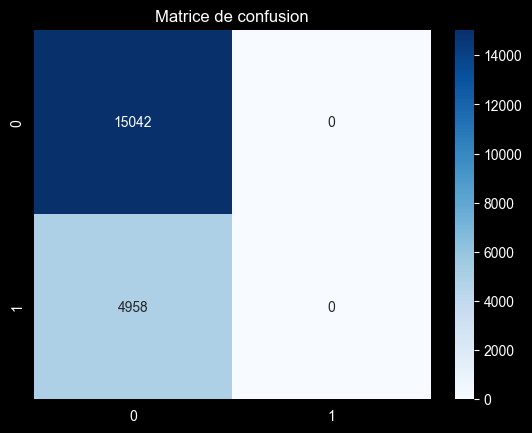

In [21]:
sns.heatmap(confusion_matrix(y_test_clas, y_pred), annot=True, fmt="d", cmap="Blues")
plt.title("Matrice de confusion")
plt.show()